<a href="https://www.kaggle.com/code/aryandec25/notebook-stackoverflow?scriptVersionId=136183097" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing all the required libraries

In [57]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


In [2]:
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
!unzip /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip

Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
  inflating: Train.csv               
Archive:  /kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip
  inflating: Test.csv                


In [3]:
df_train = pd.read_csv('/kaggle/working/Train.csv')
# df_test = pd.read_csv('/kaggle/working/Test.csv')

# Exploring the data

In [4]:
print(f'The shape of the Train dataset: {df_train.shape}')
# print(f'The shape of the Train dataset: {df_test.shape}')

The shape of the Train dataset: (6034195, 4)


In [5]:
df_train.reset_index(drop = True,inplace=True)

In [6]:
df_train.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [7]:
df_train['Body'][0]

"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>\n\n<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>\n"

In [8]:
df_train['Tags'][0]

'php image-processing file-upload upload mime-types'

In [9]:
print(f'DataFrame Shape: {df_train.shape}')

DataFrame Shape: (6034195, 4)


Since the number of records in the data is very large, we will be using a subset of the data for faster processing.

In [10]:
# df_train = df_train.iloc[:100000,:]

# print(f'Shape of the subset dataframe is: {df_train.shape}')


## Data pre-processing

### Checking for duplicates

In [11]:
duplicated_pairs = df_train.sort_values('Title', ascending=False).duplicated('Title')
print(f'Total number of duplicated questions: {duplicated_pairs.sum()}')

df_train = df_train[~duplicated_pairs]
print(f'Dataframe shape after duplicate removal: {df_train.shape}')


Total number of duplicated questions: 1908962
Dataframe shape after duplicate removal: (4125233, 4)


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4125233 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 157.4+ MB


In [14]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     7
dtype: int64

In [16]:
df_train.dropna(axis=0, inplace=True)

In [17]:
df_train.isnull().sum()

Id       0
Title    0
Body     0
Tags     0
dtype: int64

In [18]:
df_train['tag_count'] = df_train['Tags'].apply(lambda x: len(x.split()))

In [19]:
df_train.head()

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot,1


In [20]:
df_train[['Tags','tag_count']]

,Tags,tag_count
0,php image-processing file-upload upload mime-t...,5
1,firefox,1
2,r matlab machine-learning,3
3,c# url encoding,3
6,core-plot,1
...,...,...
6034190,xml facebook json status,4
6034191,php javascript,2
6034192,php sql query csv phpmyadmin,5
6034193,java spring spring-mvc view spring-roo,5


## Basic Data Analysis on Tags

### Frequency of tag_count

In [21]:
df_train['tag_count'].value_counts()

3    1182465
2    1092758
4     796044
1     560255
5     493704
Name: tag_count, dtype: int64

In [22]:
print( "Maximum number of tags in a question: ", df_train["tag_count"].max())
print( "Minimum number of tags in a question: ", df_train["tag_count"].min())
print( "Average number of tags in a question: ", df_train["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.8958078902828595


Text(0, 0.5, 'Frequency')

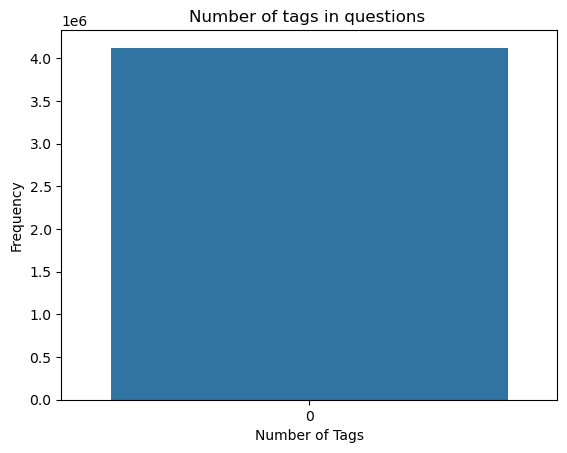

In [23]:
sns.countplot(df_train["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

In [24]:
df_train

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot,1
...,...,...,...,...,...
6034190,6034191,Parse JSON or XML in Status,<p>I wonder how Facebook parse the status or c...,xml facebook json status,4
6034191,6034192,Javascript resize on every image load,<p>I've got this code:</p>\n\n<pre><code>while...,php javascript,2
6034192,6034193,Update database with big CSV,<p>I need every day update ~ 10.000 items in m...,php sql query csv phpmyadmin,5
6034193,6034194,Difficulty adding a new view to a Roo-generate...,<p>I'm trying to add my custom view and contro...,java spring spring-mvc view spring-roo,5


Something looks odd about this

In [25]:
df_train['tag_count'].value_counts()

3    1182465
2    1092758
4     796044
1     560255
5     493704
Name: tag_count, dtype: int64

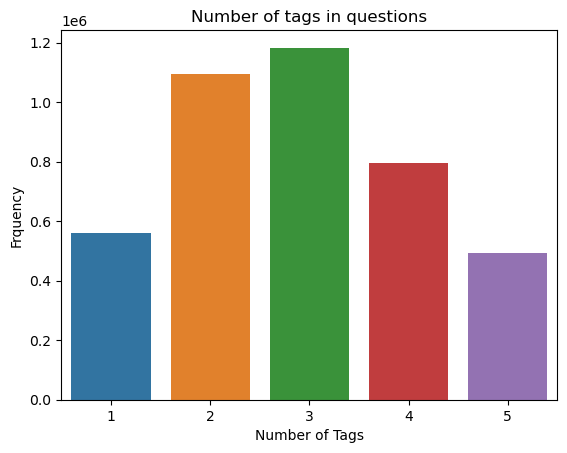

In [26]:
df_train_tag_freq = df_train['tag_count'].value_counts().reset_index().sort_values(by='index').rename(columns = {'index':'tag_count', 'tag_count':'tag_value_counts'})


plt.title('Number of tags in questions')
sns.barplot(data = df_train_tag_freq, x = 'tag_count', y = 'tag_value_counts')
plt.xlabel('Number of Tags')
plt.ylabel('Frquency')
plt.show()

This the work around we have done. 

#### Observations: 
1. Maximum number of tags in question: 5
2. Minimum number of tags in question: 1
3. Average number of tags in question: 2.89
4. Most of the questions have either 2 or 3 tags to work with.

### Total number of unique Tags

In [27]:
vectorizer = CountVectorizer(tokenizer = lambda x : x.split())
tag_bow = vectorizer.fit_transform(df_train['Tags'])

In [28]:
tag_bow.shape

(4125226, 41579)

In [29]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 4125226
Number of unique tags : 41579


In [30]:
tags = vectorizer.get_feature_names_out()
print("Few tags :", tags[:10])

Few tags : ['.a' '.app' '.asp.net-mvc' '.aspxauth' '.bash-profile' '.class-file'
 '.cs-file' '.doc' '.drv' '.ds-store']


In [31]:
df_train.head()

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot,1


### Frequency of each tag

In [32]:
freq = tag_bow.sum(axis = 0).A1
tag_to_count_map = dict(zip(tags,freq))

In [33]:
freq

array([18, 35,  1, ...,  8, 31,  1])

In [34]:
print(f'Shape of Freqeuency: {freq.shape}')
print(f'Shape of Tags: {tags.shape}')


Shape of Freqeuency: (41579,)
Shape of Tags: (41579,)


In [35]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [36]:
tag_df_train = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df_train.head()

,Tags,Counts
0,.a,18
1,.app,35
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,136


Text(0, 0.5, 'Frequency')

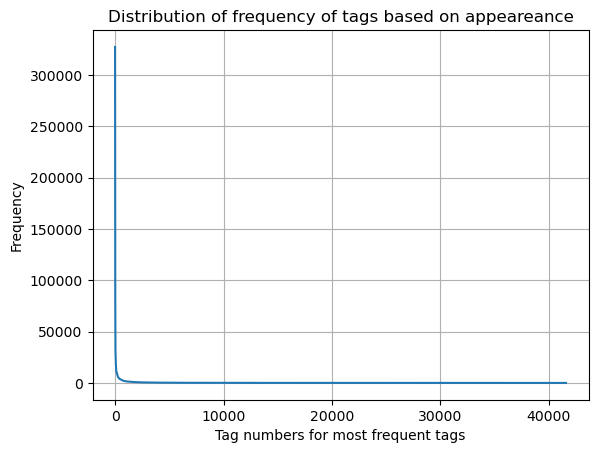

In [37]:
tag_df_train_sorted = tag_df_train.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_train_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

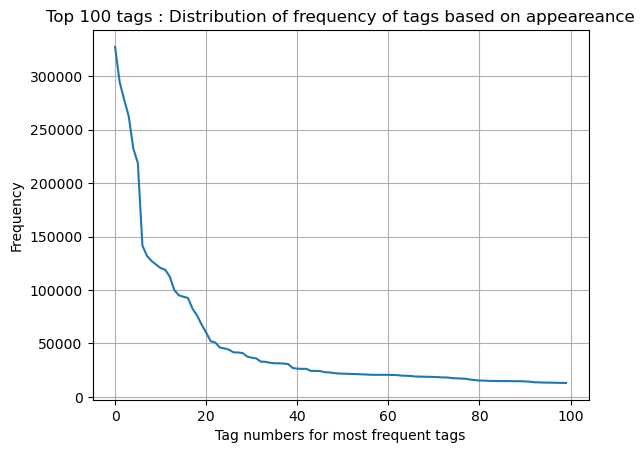

In [38]:
plt.plot(tag_df_train_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

In [39]:
tag_bow

<4125226x41579 sparse matrix of type '<class 'numpy.int64'>'
	with 11945862 stored elements in Compressed Sparse Row format>

- Cleaning up the title and body
- realtion with name of the tag and title or body
- Present of code snippet based on body. 
- Length of the body
- if any attachment  with the questions. 
- Url attachments
- Synonymn of tags in title or body.



In [40]:
df_train

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot,1
...,...,...,...,...,...
6034190,6034191,Parse JSON or XML in Status,<p>I wonder how Facebook parse the status or c...,xml facebook json status,4
6034191,6034192,Javascript resize on every image load,<p>I've got this code:</p>\n\n<pre><code>while...,php javascript,2
6034192,6034193,Update database with big CSV,<p>I need every day update ~ 10.000 items in m...,php sql query csv phpmyadmin,5
6034193,6034194,Difficulty adding a new view to a Roo-generate...,<p>I'm trying to add my custom view and contro...,java spring spring-mvc view spring-roo,5


In [41]:
df_train['Body'][1]

'<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quite often happens to me that firefox is the active window (on windows) while I still look at vim (thinking vim is the active window) and press ctrl-w which closes firefox. This is not what I want. Is there a way to stop ctrl-w from closing firefox?</p>\n\n<p>Rene</p>\n'

In [42]:
tag_df_train_sorted

,Tags,Counts
4299,c#,327237
17870,java,294500
26947,php,277885
17957,javascript,262337
1224,android,232412
...,...,...
19506,ld.so.conf,1
35878,telerik-javascript,1
31498,scenic-ribbon,1
39165,vserver,1


In [43]:
print("{} tags are used more than 25 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_train_sorted[tag_df_train_sorted["Counts"]>50].shape[0]))

17126 tags are used more than 25 times
12051 tags are used more than 50 times


### Observations:
1. 144 tags are used more than 25 times.
2. 59 tags are used more than 50 times.
3. C# is most frequently used tag 778 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

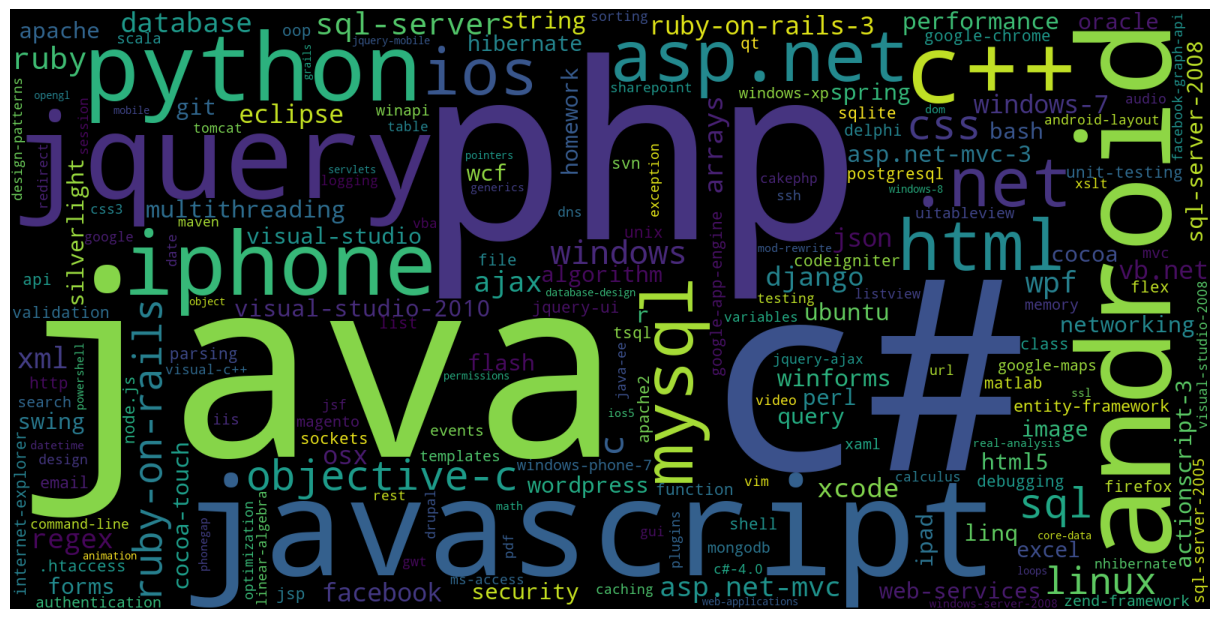

In [44]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

### Barplot of top 20 tags

In [45]:
tag_df_train_sorted.reset_index(drop=True)

,Tags,Counts
0,c#,327237
1,java,294500
2,php,277885
3,javascript,262337
4,android,232412
...,...,...
41574,ld.so.conf,1
41575,telerik-javascript,1
41576,scenic-ribbon,1
41577,vserver,1


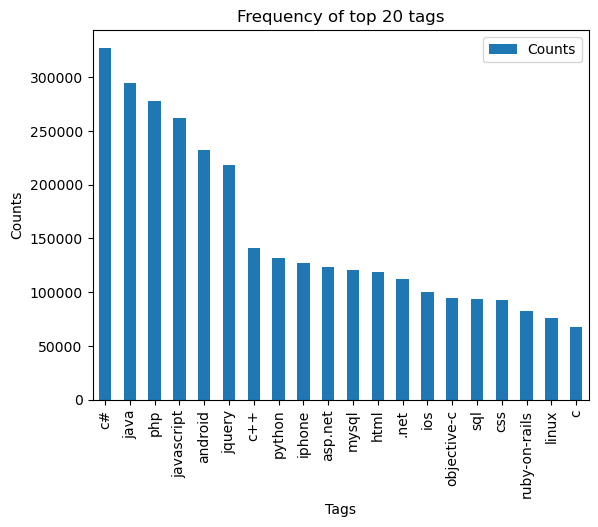

In [46]:
i=np.arange(20)
tag_df_train_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_train_sorted['Tags'].head(20))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [47]:
tag_df_train_sorted['Tags']

4299                     c#
17870                  java
26947                   php
17957            javascript
1224                android
                ...        
19506            ld.so.conf
35878    telerik-javascript
31498         scenic-ribbon
39165               vserver
41578               zzt-oop
Name: Tags, Length: 41579, dtype: object

In [48]:
df_train

,Id,Title,Body,Tags,tag_count
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot,1
...,...,...,...,...,...
6034190,6034191,Parse JSON or XML in Status,<p>I wonder how Facebook parse the status or c...,xml facebook json status,4
6034191,6034192,Javascript resize on every image load,<p>I've got this code:</p>\n\n<pre><code>while...,php javascript,2
6034192,6034193,Update database with big CSV,<p>I need every day update ~ 10.000 items in m...,php sql query csv phpmyadmin,5
6034193,6034194,Difficulty adding a new view to a Roo-generate...,<p>I'm trying to add my custom view and contro...,java spring spring-mvc view spring-roo,5


-----------------------------

## Text pre-processing

In [49]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [98]:
random_df = df_train.sample(100000)

In [99]:
random_df.head()

,Id,Title,Body,Tags,tag_count
4162830,4162831,Silverlight MediaElement double buffering,<p>I have a MediaElement that displays a simpl...,silverlight buffer mediaelement,3
5248628,5248629,How to generate graphs and charts from mysql d...,<p><strong>How can I generate graphs and chart...,php mysql graph charts,4
2175519,2175520,Can a multi-core processor run multiple proces...,<p>I understand that a multi-core processor ca...,process multi-core threads,3
2811077,2811078,How to perform a datamigration when moving fro...,<p>I'm using <code>south</code> to manage migr...,python django django-models django-south,4
762727,762728,postgis st_distance returning incorrect results,<p>I am using postgis to calculate distance be...,ruby-on-rails ruby-on-rails-3 postgresql postg...,5


In [100]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',str(data))
    return cleantext

In [101]:
start = datetime.now()
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
prepared_df = pd.DataFrame(columns=['question','code','tags','words_pre','words_post','is_code'])

for row in random_df.iterrows():

    is_code = 0

    #As title seems very important feature Hence increasing title weight by adding it 3 times
    title, question, tags = 3*(' ' +row[1][1]), row[1][2], row[1][3]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    processed_di = {
        "question": question,
        "code": code,
        "tags": tags,
        "words_pre": x,
        "words_post": len(question),
        "is_code" : is_code
    }
    
    prepared_df.loc[len(prepared_df.index)] = [question,code,tags,x,len(question),is_code]
    questions_proccesed += 1
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
Avg. length of questions(Title+Body) before processing: 1283
Avg. length of questions(Title+Body) after processing: 399
Percent of questions containing code: 57
Time taken to run this cell : 0:10:31.957836


In [103]:
prepared_df.head()

,question,code,tags,words_pre,words_post,is_code
0,silverlight mediael doubl buffer silverlight m...,['private void MediaElement_BufferingProgressC...,silverlight buffer mediaelement,900,286,1
1,generat graph chart mysql databas php generat ...,['dl'],php mysql graph charts,633,311,1
2,multi core processor run multipl process time ...,[],process multi-core threads,438,276,0
3,perform datamigr move one one one mani perform...,"['south', 'class A(models.Model):\n # bunch o...",python django django-models django-south,1752,596,1
4,postgi st distanc return incorrect result post...,"[""select st_distance(\n 'POINT(15.651955 73.7...",ruby-on-rails ruby-on-rails-3 postgresql postg...,650,271,1


In [104]:
prepared_df.shape

(100000, 6)

In [105]:
preprocessed_data = prepared_df[["question","tags"]]

In [106]:
preprocessed_data

,question,tags
0,silverlight mediael doubl buffer silverlight m...,silverlight buffer mediaelement
1,generat graph chart mysql databas php generat ...,php mysql graph charts
2,multi core processor run multipl process time ...,process multi-core threads
3,perform datamigr move one one one mani perform...,python django django-models django-south
4,postgi st distanc return incorrect result post...,ruby-on-rails ruby-on-rails-3 postgresql postg...
...,...,...
99995,chang top row cell word tabl protect chang top...,microsoft-word tables top
99996,android delet contact android delet contact an...,android
99997,call perl script insid html page call perl scr...,html perl script
99998,stop htaccess file redirect ipad user mobil si...,iphone ipad .htaccess redirect


In [64]:
## machine Learning models

In [107]:
vectorizer = CountVectorizer(tokenizer= lambda text : text.split(), binary=True)
multilabel_y = vectorizer.fit_transform(preprocessed_data["tags"])

In [108]:
multilabel_y.get_shape()

(100000, 18493)

In [109]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [110]:
question_explained = []
total_tags = multilabel_y.shape[1]
total_qs = preprocessed_data.shape[0]

for i in range(500, total_tags, 100):
    question_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

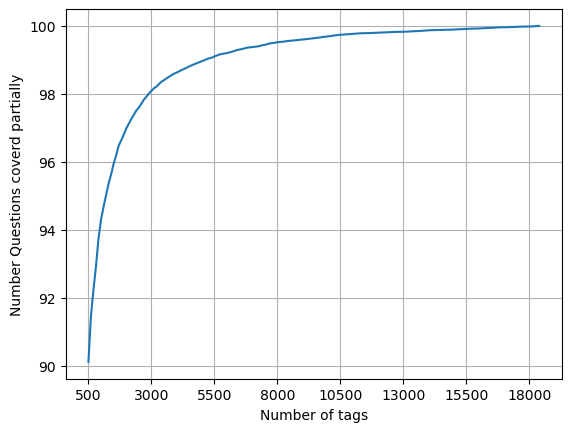

with  5500 tags we are covering  99.1 % of questions


In [111]:
fig, ax = plt.subplots()
ax.plot(question_explained)
xlabel = (500 + np.array( range(-50,450,50) )*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",question_explained[50],"% of questions")

In [112]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 900 out of  100000


In [113]:
multilabel_yx.get_shape()

(100000, 5500)

In [114]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18493
number of tags taken : 5500 ( 29.7409830746769 %)


In [81]:
## Train test split (80:20)

In [115]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [90]:
print("Number of data points in train data :", x_train.shape)
print("Number of data points in test data :", x_test.shape)

Number of data points in train data : (40000, 2)
Number of data points in test data : (10000, 2)


In [116]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 5500)
Number of data points in test data : (20000, 5500)


In [117]:
y_train.shape

(80000, 5500)

In [118]:
## Converting to vectors

In [119]:
tfidf_vect = TfidfVectorizer(min_df=0.00009,max_features=200000,smooth_idf=True,norm='l2',\
               tokenizer=lambda x : x.split(),sublinear_tf=False, ngram_range=(1,3) )

In [120]:
x_train_vectors = tfidf_vect.fit_transform(x_train['question'])
x_test_vectors = tfidf_vect.transform(x_test['question'])

In [121]:
print("Dimensions of train data X:",x_train_vectors.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_vectors.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 91459) Y : (80000, 5500)
Dimensions of test data X: (20000, 91459) Y: (20000, 5500)


In [122]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_vectors,y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=1e-05, loss='log_loss',
                                            penalty='l1'),
                    n_jobs=-1)

In [123]:
predictions = classifier.predict(x_test_vectors)

In [124]:
print("accuracy ", metrics.accuracy_score(y_test,predictions))
print("macro f1 score ",metrics.f1_score(y_test,predictions, average='macro'))
print("micro f1 score ", metrics.f1_score(y_test, predictions, average='micro'))
print("hamming loss ", metrics.hamming_loss(y_test,predictions))

accuracy  0.09005
macro f1 score  0.10064145640017136
micro f1 score  0.4004288681900422
hamming loss  0.0004067


## Bi-Directional LSTM

In [ ]:
prepas

In [ ]:
# tokenize words in title
t = Tokenizer(num_words=20000)
t.fit_on_texts(train['Title'].to_list())